In [11]:
#Import
import pandas as pd
import cv2
import numpy as np
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical   
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input



from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import re
import contractions

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gc



In [12]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU')) 

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
nltk.download('words')
nltk.download('stopwords')
nltk.download('punkt')
additional  = ['rt','rts','retweet'] # lista adicional de stopwords
swords = set().union(stopwords.words('english'),additional) # adicionando palavras para o stopwords

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\bhla\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bhla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
path = "dataset_sidi_v1.2.csv"

df512 = pd.read_csv(path, sep='\t')
df512

,Unnamed: 0,image_name,NEG,NEU,POS,text,sent_text,sent_image,image_path,image_height,image_width
0,0,768097808037605376-1,0.919993,0.055681,0.024326,"RT @hoseokahhh: ""who is this song forwhat do i...",NEG,0,data/76809/768097808037605376-1.jpg,449,449
1,1,768097833215938560-1,0.864726,0.058440,0.076834,RT @ARapperSaid_: “I ain’t come over here for ...,NEG,0,data/76809/768097833215938560-1.jpg,398,593
2,2,768097929659817984-1,0.907574,0.061396,0.031029,RT @blackedfriction: i hate telling people i l...,NEG,0,data/76809/768097929659817984-1.jpg,489,1132
3,3,768097929659817984-2,0.907574,0.061396,0.031029,RT @blackedfriction: i hate telling people i l...,NEG,0,data/76809/768097929659817984-2.jpg,983,1123
4,4,768097929659817984-3,0.907574,0.061396,0.031029,RT @blackedfriction: i hate telling people i l...,NEG,0,data/76809/768097929659817984-3.jpg,1326,1110
...,...,...,...,...,...,...,...,...,...,...,...
470581,470581,804618699315539969-1,0.453963,0.387611,0.158427,Chances not to loose&gt;&gt;&gt;https://t.co/j...,NEG,0,data/80461/804618699315539969-1.jpg,183,275
470582,470582,804618854466981888-1,0.651498,0.208690,0.139812,Don't hear this much RT @phillynewsnow: Lyft ...,NEG,0,data/80461/804618854466981888-1.jpg,675,1200
470583,470583,804619265546387457-1,0.473848,0.382078,0.144074,Security agencies threaten to assassinate me –...,NEG,0,data/80461/804619265546387457-1.jpg,682,1024
470584,470584,804619315861393408-1,0.402850,0.337901,0.259249,"Kill my trusted old assistant? Why, no. I'm go...",NEG,0,data/80461/804619315861393408-1.jpg,458,626


In [16]:
grupo=[]
path =[]
with open("./Dataset/b-t4sa_imgs/b-t4sa_train.txt", "r") as f:
    line = f.readlines()
f.close()

for i in line:
    path.append(i.split(" ")[0])
    grupo.append("train")
    
with open("./Dataset/b-t4sa_imgs/b-t4sa_val.txt", "r") as f:
    line = f.readlines()
f.close()

for i in line:
    path.append(i.split(" ")[0])
    grupo.append("val")
    
    
with open("./Dataset/b-t4sa_imgs/b-t4sa_test.txt", "r") as f:
    line = f.readlines()
f.close()

for i in line:
    path.append(i.split(" ")[0])
    grupo.append("test")



In [17]:
df_aux = pd.DataFrame()
df_aux["path"] = path
df_aux["grupo"] = grupo
df_aux = df_aux.set_index("path")
df_aux

,grupo
path,
data/78476/784760943188189184-1.jpg,train
data/78226/782267072923525120-1.jpg,train
data/80180/801804526848278529-1.jpg,train
data/76927/769271101667016704-3.jpg,train
data/79618/796181957453512704-1.jpg,train
...,...
data/76918/769186708067876864-1.jpg,test
data/78112/781129758017019904-1.jpg,test
data/78166/781662543689515058-1.jpg,test


In [18]:
df512 = df512.set_index("image_path")
df512 

,Unnamed: 0,image_name,NEG,NEU,POS,text,sent_text,sent_image,image_height,image_width
image_path,,,,,,,,,,
data/76809/768097808037605376-1.jpg,0,768097808037605376-1,0.919993,0.055681,0.024326,"RT @hoseokahhh: ""who is this song forwhat do i...",NEG,0,449,449
data/76809/768097833215938560-1.jpg,1,768097833215938560-1,0.864726,0.058440,0.076834,RT @ARapperSaid_: “I ain’t come over here for ...,NEG,0,398,593
data/76809/768097929659817984-1.jpg,2,768097929659817984-1,0.907574,0.061396,0.031029,RT @blackedfriction: i hate telling people i l...,NEG,0,489,1132
data/76809/768097929659817984-2.jpg,3,768097929659817984-2,0.907574,0.061396,0.031029,RT @blackedfriction: i hate telling people i l...,NEG,0,983,1123
data/76809/768097929659817984-3.jpg,4,768097929659817984-3,0.907574,0.061396,0.031029,RT @blackedfriction: i hate telling people i l...,NEG,0,1326,1110
...,...,...,...,...,...,...,...,...,...,...
data/80461/804618699315539969-1.jpg,470581,804618699315539969-1,0.453963,0.387611,0.158427,Chances not to loose&gt;&gt;&gt;https://t.co/j...,NEG,0,183,275
data/80461/804618854466981888-1.jpg,470582,804618854466981888-1,0.651498,0.208690,0.139812,Don't hear this much RT @phillynewsnow: Lyft ...,NEG,0,675,1200
data/80461/804619265546387457-1.jpg,470583,804619265546387457-1,0.473848,0.382078,0.144074,Security agencies threaten to assassinate me –...,NEG,0,682,1024


In [19]:
df = pd.concat([df_aux, df512 ], axis=1)
df = df.reset_index()
df = df.rename(columns={"index": "image_path"})
df

,image_path,grupo,Unnamed: 0,image_name,NEG,NEU,POS,text,sent_text,sent_image,image_height,image_width
0,data/78476/784760943188189184-1.jpg,train,339053,784760943188189184-1,0.855467,0.079337,0.065196,"this sounds depressing to me, a cat lover, htt...",NEG,0,452,1206
1,data/78226/782267072923525120-1.jpg,train,223402,782267072923525120-1,0.004412,0.020115,0.975473,Jerry is having lunch with a view today! It's ...,POS,2,1024,1024
2,data/80180/801804526848278529-1.jpg,train,432621,801804526848278529-1,0.506770,0.076925,0.416305,My favorite dancer that I didn't give birth to...,NEG,0,960,720
3,data/76927/769271101667016704-3.jpg,train,48426,769271101667016704-3,0.022343,0.088038,0.889619,Happy #Frankfriday https://t.co/UFrAcCuM2K,POS,2,769,500
4,data/79618/796181957453512704-1.jpg,train,352093,796181957453512704-1,0.559047,0.276885,0.164069,Gross. https://t.co/u9Nx5Vsqym,NEG,0,550,968
...,...,...,...,...,...,...,...,...,...,...,...,...
470581,data/76918/769186708067876864-1.jpg,test,28655,769186708067876864-1,0.963062,0.029000,0.007938,When Ashton Kutcher was 13 he almost committed...,NEG,0,373,646
470582,data/78112/781129758017019904-1.jpg,test,163922,781129758017019904-1,0.037230,0.078174,0.884596,As I Like¡ Beautiful Eyes and Fleshy Pussy #Em...,POS,2,896,640
470583,data/78166/781662543689515058-1.jpg,test,193186,781662543689515058-1,0.029257,0.853053,0.117690,✴ Short Imagine - Jimin ✴ 🔥Hot🔥 ht...,NEU,1,701,555
470584,data/78243/782431204448567296-1.jpg,test,231660,782431204448567296-1,0.010773,0.070125,0.919102,A salute to the legend for his contribution to...,POS,2,1200,1200


Drop das imagens e seus tweets correspondentes com tamanho menor que width e height.

In [20]:
width = 128
height = 128
channels = 3
df = df[(df["image_height"]>=height) &(df["image_width"]>=width)]
print("Novos valores de Treino, teste e validação.")
df[(df["image_height"]>=height) &(df["image_width"]>=width)]["grupo"].value_counts()

Novos valores de Treino, teste e validação.


train    362405
val       50193
test      50138
Name: grupo, dtype: int64

In [21]:
x_train = df[df["grupo"]=="train"]
x_test = df[df["grupo"]=="test"]
x_val = df[df["grupo"]=="val"]

y_train =  x_train['sent_image'].tolist()
y_val =  x_val['sent_image'].tolist()
y_test =  x_test['sent_image'].tolist()

In [22]:
#tokenização
t  = Tokenizer()
t.fit_on_texts(df512['text'].tolist())

#Bi-LSTM
x_train_BiLSTM = t.texts_to_sequences(x_train['text'].tolist())
x_val_BiLSTM = t.texts_to_sequences(x_val['text'].tolist())
x_test_BiLSTM = t.texts_to_sequences(x_test['text'].tolist())

#VADER
x_test_VADER = x_test["text"]

##VGG19
x_train = ['./Dataset/b-t4sa_imgs/' + fname for fname in x_train['image_path'].tolist()]
x_val = ['./Dataset/b-t4sa_imgs/' + fname for fname in x_val['image_path'].tolist()]
x_test = ['./Dataset/b-t4sa_imgs/' + fname for fname in x_test['image_path'].tolist()]
 

In [23]:
#Mudando o formato para suporta o softmax na rede
#saindo do formato [2] para [0,0,1]
y_train = to_categorical(y_train, num_classes=3)
#y_test = to_categorical(y_test, num_classes=3)

y_val = to_categorical(y_val, num_classes=3)

## VADER

In [24]:
def tweet_to_VADER_sentiment(tweet):

    sid_obj = SentimentIntensityAnalyzer()
    
    text = re.sub("@[A-Za-z0-9_]+","", tweet) #remove menções
    text = re.sub("#[A-Za-z0-9_]+","", text)  # remove hashtag
   
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", text) 
    words = word_tokenize(text)
    
    words = [w for w in words if w not in stopwords.words("english")]

    sentiment_dict = sid_obj.polarity_scores(tweet)

        # decide sentiment as positive, negative and neutral
    if sentiment_dict['compound'] >= 0.05 :
        return 2
 
    elif sentiment_dict['compound'] <= - 0.05 :
        return  0
 
    else :
        return 1

Predição do VADER

In [25]:
y_pred_VADER = [tweet_to_VADER_sentiment(i) for i in x_test_VADER]

## Bi-LSTM


In [26]:
maxlen = 100
max_features = 10000
x_train_BiLSTM = keras.preprocessing.sequence.pad_sequences(x_train_BiLSTM, maxlen=maxlen)
x_val_BiLSTM = keras.preprocessing.sequence.pad_sequences(x_val_BiLSTM, maxlen=maxlen)
x_test_BiLSTM = keras.preprocessing.sequence.pad_sequences(x_test_BiLSTM, maxlen=maxlen)

In [27]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

0

In [28]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

100

In [29]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

100

In [30]:
#Arquitetura base da página https://keras.io/examples/nlp/bidirectional_lstm_imdb/
#Modificação feita na saida (3) e na acitivação da saida (solftmax)


inputs = keras.Input(shape=(None,), dtype="int32")

x = layers.Embedding(max_features, 128)(inputs)

x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)

outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,478,019
Trainable params: 1,478,019
Non-train

In [31]:
#Compilando com lr de 0.001
model.compile(Adam(learning_rate=0.001), "categorical_crossentropy", metrics=["accuracy"])

#fazneodo early top quando o loss da validação aumentar
es = EarlyStopping(monitor='val_loss', verbose=1, patience=1,restore_best_weights=True)

#treinando
history_BiLSTM = model.fit(x_train_BiLSTM, y_train, batch_size=300, epochs=20, validation_data=(x_val_BiLSTM, y_val),callbacks=[es])

Epoch 1/20
1209/1209 [==============================] - 51s 36ms/step - loss: 0.2228 - accuracy: 0.9176 - val_loss: 0.1547 - val_accuracy: 0.9463
Epoch 2/20
1209/1209 [==============================] - 44s 36ms/step - loss: 0.1303 - accuracy: 0.9558 - val_loss: 0.1361 - val_accuracy: 0.9537
Epoch 3/20
1209/1209 [==============================] - 44s 36ms/step - loss: 0.1098 - accuracy: 0.9627 - val_loss: 0.1330 - val_accuracy: 0.9552
Epoch 4/20
1209/1209 [==============================] - 44s 36ms/step - loss: 0.0923 - accuracy: 0.9685 - val_loss: 0.1337 - val_accuracy: 0.9556
Epoch 00004: early stopping


Predição do Bi-LSTM

In [32]:
y_pred_BiLSTM = model.predict(x_test_BiLSTM)
y_pred_BiLSTM =(y_pred_BiLSTM>0.5)
y_pred_BiLSTM = np.argmax(y_pred_BiLSTM, axis=-1)


## VGG19 adaptada

In [33]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

2592

In [34]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

100

In [35]:
#Para limpar memória
tf.keras.backend.clear_session()
gc.collect()

100

In [36]:
base_model = VGG19(weights=None, include_top=False, input_shape=(width, height, channels))
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [37]:
flatten_layer = layers.Flatten()
dense1 = layers.Dense(1028, activation='relu')
dense2 = layers.Dense(1028, activation='relu')
prediction_layer = layers.Dense(3, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense1,
    dense2,
    prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1028)              8422404   
                                                                 
 dense_1 (Dense)             (None, 1028)              1057812   
                                                                 
 dense_2 (Dense)             (None, 3)                 3087      
                                                                 
Total params: 29,507,687
Trainable params: 29,507,687
Non-trainable params: 0
_________________________________________________________________


In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.000002)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [39]:
#busca os dados que estão listados em train_filenames
import random
def generate_data(train_filenames,train_labels, batch_size,width, height,channels):
    dim = (width, height)
    while True:
        
        mistura = list(zip(train_filenames, train_labels))
        random.shuffle(mistura)
        train_filenames, train_labels = zip(*mistura)
        
        for i in range(0,len(train_filenames),batch_size):
            
            if  i+batch_size > len(train_filenames):
                bs = len(train_filenames)%batch_size
            else:
                bs = batch_size
            
            X_train = np.zeros((int(bs), width, height, channels))
            aux =0

            dim = (width, height)

            for j in train_filenames[i:i+ bs]:
                X_train[aux] =  np.asarray(cv2.resize(cv2.imread(j), dim, interpolation = cv2.INTER_AREA) )
                aux = aux + 1
                
            #img = X_train.reshape(( X_train.shape[0],) +(width, height,channels)).astype('float32') / 255.
            img = preprocess_input( X_train) 
            
            yield (img, np.array(train_labels[i:i+ bs]))

In [40]:
#dobra para 48 pra vê se tanka

batch_size=36

validation_steps = int(len(x_val)/batch_size)+(0 if len(x_val)%batch_size==0 else 1)
steps_per_epoch = int(len(x_train)/batch_size)+(0 if len(x_train)%batch_size==0 else 1)
steps_per_epoch,validation_steps,batch_size

(10067, 1395, 36)

In [41]:
es = EarlyStopping(monitor='val_loss', patience=1,  restore_best_weights=True)
epocas = 500

history_VGG19 = model.fit( generate_data(x_train, y_train, batch_size,width, height,channels),
          validation_steps=validation_steps,steps_per_epoch=steps_per_epoch,
          callbacks=[es], batch_size=batch_size,  epochs=epocas,
          validation_data=generate_data(x_val,y_val, batch_size,width, height,channels))

Epoch 1/500
10067/10067 [==============================] - 11547s 1s/step - loss: 1.0794 - accuracy: 0.4019 - val_loss: 1.0716 - val_accuracy: 0.4142
Epoch 2/500
10067/10067 [==============================] - 8040s 799ms/step - loss: 1.0640 - accuracy: 0.4276 - val_loss: 1.0626 - val_accuracy: 0.4267
Epoch 3/500
10067/10067 [==============================] - 8022s 797ms/step - loss: 1.0562 - accuracy: 0.4388 - val_loss: 1.0615 - val_accuracy: 0.4310
Epoch 4/500
10067/10067 [==============================] - 8020s 797ms/step - loss: 1.0507 - accuracy: 0.4451 - val_loss: 1.0565 - val_accuracy: 0.4394
Epoch 5/500
10067/10067 [==============================] - 8018s 797ms/step - loss: 1.0447 - accuracy: 0.4521 - val_loss: 1.0518 - val_accuracy: 0.4426
Epoch 6/500
10067/10067 [==============================] - 8014s 796ms/step - loss: 1.0385 - accuracy: 0.4594 - val_loss: 1.0611 - val_accuracy: 0.4433


In [42]:
##generator para teste pra tankar com rede maior
def generate_data_teste(train_filenames, batch_size,width, height,channels):
    dim = (width, height)
    while True:
        
        
        for i in range(0,len(train_filenames),batch_size):
            
            if  i+batch_size > len(train_filenames):
                bs = len(train_filenames)%batch_size
            else:
                bs = batch_size
            
            X_train = np.zeros((int(bs), width, height, channels))
            aux =0

            dim = (width, height)

            for j in train_filenames[i:i+ bs]:
                X_train[aux] =  np.asarray(cv2.resize(cv2.imread(j), dim, interpolation = cv2.INTER_AREA) )
                aux = aux + 1
                
           # img = X_train.reshape(( X_train.shape[0],) +(width, height,channels)).astype('float32') / 255.
            img = preprocess_input(X_train) 
            
            yield (img)

Predição da VGG19 Adaptada

In [58]:
test_steps = int(len(x_test)/batch_size)+(0 if len(x_test)%batch_size==0 else 1)
test_steps,validation_steps

(1393, 1395)

In [59]:
y_pred_vgg = model.predict(generate_data_teste(x_test,batch_size,width, height,channels),steps=test_steps)

y_pred_vgg = np.argmax(y_pred_vgg, axis=-1)

## Resultados

### Bi-LSTM peso 1.5

In [60]:
labels_pred = pd.DataFrame()
labels_pred["VADER"] = y_pred_VADER
labels_pred["VADER_2"] = y_pred_VADER
labels_pred["BiLSTM"] = y_pred_BiLSTM
labels_pred["BiLSTM_Peso_2"] = y_pred_BiLSTM
labels_pred["BiLSTM_Peso_3"] = y_pred_BiLSTM
labels_pred["VGG"] = y_pred_vgg
labels_pred["VGG_2"] = y_pred_vgg
labels_pred



,VADER,VADER_2,BiLSTM,BiLSTM_Peso_2,BiLSTM_Peso_3,VGG,VGG_2
0,2,2,2,2,2,0,0
1,2,2,0,0,0,1,1
2,2,2,2,2,2,0,0
3,1,1,0,0,0,0,0
4,2,2,2,2,2,1,1
...,...,...,...,...,...,...,...
50133,2,2,0,0,0,0,0
50134,2,2,2,2,2,1,1
50135,0,0,1,1,1,1,1
50136,2,2,2,2,2,1,1


In [61]:
moda = labels_pred.mode(axis =1)
y_pred = moda[0].tolist()

In [62]:
#y_test = np.argmax(y_test, axis=-1)

print(accuracy_score(y_test, y_pred));
print(classification_report(y_test, y_pred));

0.8827835174917228
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     16805
           1       0.89      0.86      0.87     16416
           2       0.84      0.94      0.89     16917

    accuracy                           0.88     50138
   macro avg       0.89      0.88      0.88     50138
weighted avg       0.89      0.88      0.88     50138



Negativo - 0     Neutro - 1      Positivo - 2


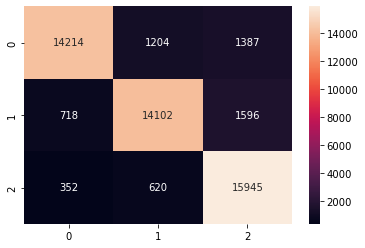

In [63]:
print("Negativo - 0     Neutro - 1      Positivo - 2")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d");

In [64]:
m = confusion_matrix(y_test, y_pred)
print("Acuracia de cada classe")
print("Negativo - 0     Neutro - 1      Positivo - 2")
m.diagonal()/m.sum(axis=1)

Acuracia de cada classe
Negativo - 0     Neutro - 1      Positivo - 2


array([0.8458197 , 0.85903996, 0.942543  ])

### Bi-LSTM peso 2

In [65]:
labels_pred = pd.DataFrame()
labels_pred["VADER"] = y_pred_VADER
#labels_pred["VADER_2"] = y_pred_VADER
labels_pred["BiLSTM"] = y_pred_BiLSTM
labels_pred["BiLSTM_Peso_2"] = y_pred_BiLSTM
#labels_pred["BiLSTM_Peso_3"] = y_pred_BiLSTM
labels_pred["VGG"] = y_pred_vgg
#labels_pred["VGG_2"] = y_pred_vgg


moda = labels_pred.mode(axis =1)
y_pred = moda[0].tolist()


print(accuracy_score(y_test, y_pred));
print(classification_report(y_test, y_pred));



0.9437352905979497
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     16805
           1       0.93      0.93      0.93     16416
           2       0.98      0.93      0.95     16917

    accuracy                           0.94     50138
   macro avg       0.94      0.94      0.94     50138
weighted avg       0.94      0.94      0.94     50138



Negativo - 0     Neutro - 1      Positivo - 2


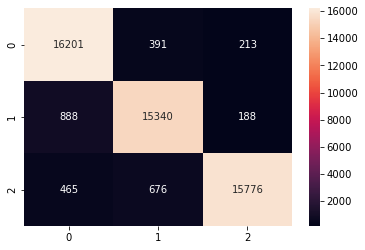

In [66]:
print("Negativo - 0     Neutro - 1      Positivo - 2")
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d");

In [67]:
m = confusion_matrix(y_test, y_pred)
print("Acuracia de cada classe")
print("Negativo - 0     Neutro - 1      Positivo - 2")
m.diagonal()/m.sum(axis=1)

Acuracia de cada classe
Negativo - 0     Neutro - 1      Positivo - 2


array([0.96405832, 0.93445419, 0.93255305])

### Tamanho dos tamanhos dos grupos

In [68]:
len(x_train),len(x_val),len(x_test)

(362405, 50193, 50138)